In [1]:
import logging
import warnings
from ProphetLightGMBPredictor import ProphetLightGMBPredictor
import os
import pandas as pd
import cmdstanpy
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.boxcox import BoxCoxTransformer
# Подавление всех логов cmdstanpy
logging.getLogger("cmdstanpy").disabled = True
# Установите уровень логирования в WARNING или ERROR, чтобы не выводить INFO-сообщения
logging.getLogger('prophet').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
models_path = "models"

In [3]:
if not os.path.exists(models_path):
    os.makedirs(models_path)  # Создаём папку, если её нет


В качестве итоговой модели взято решение из второго задания - Prophet + LightGBM. Prophet для оценки тренда и прогноза тренда, на  дерендированным уже обучаем LightGBM. Соотвественно дальше будут сохраняться и подгружаться две модели по отдельности. Фичи и обработка таргета не менялась, продублирую.

1) Обработка данных.
В качестве фичей были взяты сплит даты, цена товара, wday - номер дня в недели. Лаги было решено не использовать вовсе.
2) Бейзлайн обработка для таргета не изменилась. Срезается продолжительный отрезок из нулевых значений с начала отсчёта, если он есть( было несколько рядов, для которых пару сотен первых наблюдений нулевые). Ряд поднимается на единицу, IForest-ом находим выбросы, заменяем  медианой соседних.

Приведём пример работы

In [4]:
sales = pd.read_csv('shop_sales.csv')
sales_dates = pd.read_csv('shop_sales_dates.csv')
sales_prices = pd.read_csv('shop_sales_prices.csv')

In [5]:
tsp_store2 = ProphetLightGMBPredictor(sales, sales_dates, sales_prices, "STORE_2", models_path)

In [6]:
tsp_store2.items_names# имена айтемов

array(['STORE_2_085', 'STORE_2_043', 'STORE_2_054', 'STORE_2_090',
       'STORE_2_252', 'STORE_2_376', 'STORE_2_524', 'STORE_2_555',
       'STORE_2_586', 'STORE_2_587', 'STORE_2_681', 'STORE_2_714',
       'STORE_2_325', 'STORE_2_391', 'STORE_2_716'], dtype=object)

In [7]:
item_name = tsp_store2.items_names[4]
h_forecast = 90
ts_test = tsp_store2.get_preprocessed_item_data(item_name)
x_train, y_train, x_test , y_test = tsp_store2.split_train_test(ts_test, h_forecast)

Обучаем и сохраняем модели. Под свой айтем и под свой горизонт прогноза своя модель

In [8]:
prophet_model_trained, lightgbm_model_trained = tsp_store2.fit(x_train, y_train)
tsp_store2.save_models(item_name, h_forecast, prophet_model_trained, lightgbm_model_trained)

models\lightgbm_STORE_2_252_90.pkl
models\prophet_STORE_2_252_90.pkl


Подгружаем модели для заданного айтема и делаем предикт

In [9]:
prophet_model, lightgbm_model = tsp_store2.load_models(item_name, h_forecast)
y_pred = tsp_store2.predict(x_test,prophet_model,lightgbm_model)
y_pred = pd.Series(y_pred, index=y_test.index)

Визуальная оценка

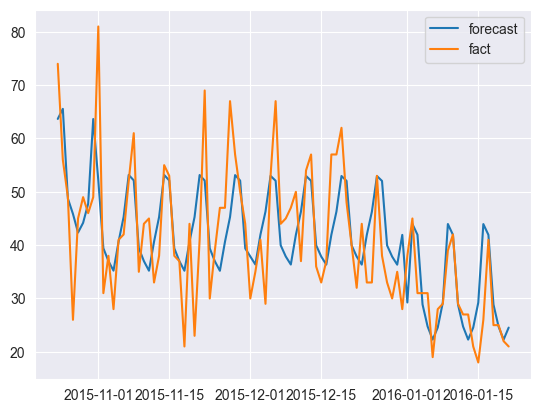

                 mean     median    quan_75    quan_95        std
maes         6.663456   4.902139   9.516789  17.659979   5.978178
maes_zero   10.384198   9.355556  14.572222  24.685556   7.755956
mapes       18.041531  14.657074  24.955303  61.189147  18.454072
mapes_zero  28.846620  23.164983  39.336650  89.586099  25.588318
smapes      16.535348  15.279292  23.902990  46.850023  14.375834


In [10]:
tsp_store2.show_result(y_pred, y_test)

Попробуем для третьего магазина 

In [13]:
tsp_store3 = ProphetLightGMBPredictor(sales, sales_dates, sales_prices, "STORE_3", models_path)
item_name = tsp_store3.items_names[3]
h_forecast = 90
ts_test = tsp_store3.get_preprocessed_item_data(item_name)
x_train, y_train, x_test , y_test = tsp_store3.split_train_test(ts_test, h_forecast)
prophet_model_trained, lightgbm_model_trained = tsp_store3.fit(x_train, y_train)
tsp_store3.save_models(item_name, h_forecast, prophet_model_trained, lightgbm_model_trained)

models\lightgbm_STORE_3_252_90.pkl
models\prophet_STORE_3_252_90.pkl


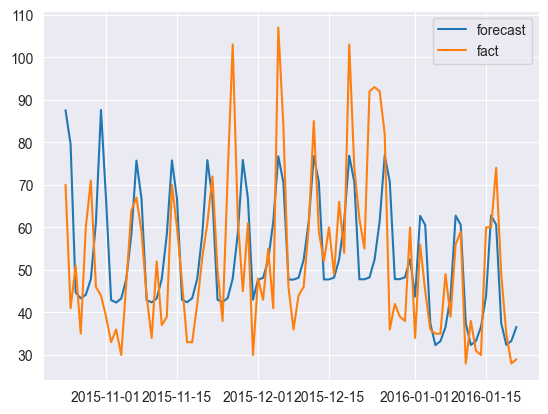

                 mean     median    quan_75    quan_95        std
maes        11.703867   7.960892  13.539789  36.850174  11.036181
maes_zero   14.644444  13.500000  19.166667  39.333333  11.181155
mapes       22.694715  17.166613  28.538344  61.762936  20.075600
mapes_zero  29.953458  25.396825  45.564516  75.555556  21.715176
smapes      21.265648  17.322117  28.218430  59.409828  16.528514


In [14]:
prophet_model, lightgbm_model = tsp_store3.load_models(item_name, h_forecast)
y_pred = tsp_store3.predict(x_test,prophet_model,lightgbm_model)
y_pred = pd.Series(y_pred, index=y_test.index)
tsp_store3.show_result(y_pred, y_test)

Форекастить можно на любой промежуток, но отсчёт будет вестись, естественно, с последней даты на трейне